# Не бит, не крашен

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Загрузка данных

### Библиотеки

Импортируем библиотеки.

In [2]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

Убрираем длинные циферки.

In [4]:
pd.set_option('display.float_format', '{:,.3f}'.format)

Отключаем лишние предупреждения.

In [5]:
import warnings
warnings.filterwarnings('ignore')

### Функции

#### calc_gscv

In [139]:
def calc_gscv(model, features, target, params):
    '''
    Функция для поиска оптимальных параметров и расчета RMSE по этим параметрам на обучающей выборке.
    '''
    grid = GridSearchCV(model,
                        params,
                        #scoring = 'neg_mean_squared_error',
                        scoring = 'neg_root_mean_squared_error',
                        cv = 5,
                        n_jobs = -1)
    grid.fit(features,
             target)
    rmse = (-grid.best_score_)**0.5
    print('RMSE модели на обучающей выборке: {:.2f}'.format(rmse))
    print('Лучшие гиперпараметры для модели: ', grid.best_params_)

In [17]:
def column_values(data_frame):
    '''
    Функция для визуального поиска артефактов и выбросов в значениях DataFrame
    '''
    for column in data_frame.columns:
        print('\nЗначения столбца', column,':')
        print(data_frame[column].sort_values().unique())
        display(data_frame[column].hist(bins = 100))
        plt.title("Распределение", column,':')
        plt.show()
        display(ax = sns.boxplot(data = data_frame,
                                 x = column,
                                 orient = 'h'))
        plt.title("Распределение значений", column,':')
        plt.show()

#### df_info

In [8]:
def df_info(data_frame):
    '''
    Функция выводящая первичную информацию о DataFrame
    '''
    print('\nИнфо:')
    print(data_frame.info())                                            # сколько значений и в каком формате
    print('\nПропусков:')
    print(data_frame.isna().mean().sort_values(ascending=False) * 100)  # подсчёт пропусков в процентах
    print('\nОписание:')
    display(data_frame.describe())                                      # вдруг чего "на глазок" проявится 
    print('\nДубликатов =', data_frame.duplicated().sum())              # проверим дубликаты

#### percentage_of_nan

In [9]:
def percentage_of_nan(data_frame):
    '''
    Функция для визуализации количества пропусков в процентах
    '''
    columns = data_frame.columns.values.tolist()
    nan = []

    for col in columns:
      not_nan_count = data_frame[col].count()
      percent = ((len(data_frame) - not_nan_count) / len(data_frame)) * 100
      nan.append(percent)

    nan_percent_before = pd.Series(nan,
                                   index = columns)
    nan_percent_before_mean = nan_percent_before.mean()
    nan_percent_before.sort_values(ascending = True,
                                   inplace = True)

    fig, ax = plt.subplots(figsize = (12, 8))
    ax.barh(nan_percent_before.index,
            nan_percent_before.values)
    ax.set_title('Процент пропусков значений по столбцам')

    # Добавим на график цифры значений
    for i in ax.patches:
      plt.text(i.get_width() + 0.5,
               i.get_y() + 0.2,
               str(round(i.get_width(), 1)),
               fontsize = 10,
               fontweight = 'bold',
               color = 'black')
    # Построим линию, показывающую средний % пропусков по столбцам
    plt.axvline(x = nan_percent_before_mean,
                linewidth = 2,
                label = 'Средний % пропусков по столбцам = {}'.format(round(nan_percent_before_mean, 1)),
                color='r',
                linestyle='--')
    plt.legend()
    plt.show()

### Таблица

Читаем файл с данными и сохраняем в df.

In [10]:
try:
    path = '/datasets/'
    df = pd.read_csv(os.path.join(path,
                                  'autos.csv',
                                  parse_dates=['DateCrawled',
                                               'DateCreated',
                                               'LastSeen']))
except Exception:
    ! gdown --id 1WcybmU4TZoaSmsKgvtjwvcrBWKYTw1d2
    df = pd.read_csv('/content/autos.csv',
                     parse_dates=['DateCrawled',
                                  'DateCreated',
                                  'LastSeen'])

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1WcybmU4TZoaSmsKgvtjwvcrBWKYTw1d2
To: /content/autos.csv
100% 44.4M/44.4M [00:00<00:00, 60.8MB/s]


Смотрим табличку.

In [11]:
display(df.columns)
print()
display(df.head())

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


#### Описание данных

Признаки

	• DateCrawled       • дата_скачивания           • дата скачивания анкеты из базы
	• VehicleType       • кузов                     • тип автомобильного кузова
	• RegistrationYear  • год_регистрации           • год регистрации автомобиля
	• Gearbox           • кор_передач               • тип коробки передач
	• Power             • мощность                  • мощность (л. с.)
	• Model             • модель                    • модель автомобиля
	• Kilometer         • пробег                    • пробег (км)
	• RegistrationMonth • месяц_регистрации         • месяц регистрации автомобиля
	• FuelType          • топливо                   • тип топлива
	• Brand             • марка                     • марка автомобиля
	• NotRepaired       • ремонт                    • была машина в ремонте или нет
	• DateCreated       • дата_анкеты               • дата создания анкеты
	• NumberOfPictures  • кол_фото                  • количество фотографий автомобиля
	• PostalCode        • почт_индекс     • почтовый индекс владельца анкеты (пользователя)
	• LastSeen          • посл_активн  • дата последней активности пользователя

Целевой признак

	• Price             • цена                      • цена (евро)

"Шапку" к стандартному виду.

In [12]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
display(df.head())

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


#### df_rus

Табличку к рабочему виду.

In [22]:
df_rus = df.rename(columns={'date_crawled': 'дата_скачивания',
                            'vehicle_type': 'кузов',
                            'registration_year': 'год_регистрации',
                            'gearbox': 'кор_передач',
                            'power': 'мощность',
                            'model': 'модель',
                            'kilometer': 'пробег',
                            'registration_month': 'месяц_регистрации',
                            'fuel_type': 'топливо',
                            'brand': 'марка',
                            'not_repaired': 'ремонт',
                            'date_created': 'дата_анкеты',
                            'number_of_pictures': 'кол_фото',
                            'postal_code': 'почт_индекс',
                            'last_seen': 'посл_активн',
                            'price': 'цена'})
display(df_rus)

,дата_скачивания,цена,кузов,год_регистрации,кор_передач,мощность,модель,пробег,месяц_регистрации,топливо,марка,ремонт,дата_анкеты,кол_фото,почт_индекс_владельца,посл_активн_пользователя
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26


#### Инфо

Посмотрим заполненость таблицы.

In [23]:
df_info(df_rus)

# Добавили преобразование дат в чтение файла


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   дата_скачивания           354369 non-null  datetime64[ns]
 1   цена                      354369 non-null  int64         
 2   кузов                     316879 non-null  object        
 3   год_регистрации           354369 non-null  int64         
 4   кор_передач               334536 non-null  object        
 5   мощность                  354369 non-null  int64         
 6   модель                    334664 non-null  object        
 7   пробег                    354369 non-null  int64         
 8   месяц_регистрации         354369 non-null  int64         
 9   топливо                   321474 non-null  object        
 10  марка                     354369 non-null  object        
 11  ремонт                    283215 non-null  object        


,цена,год_регистрации,мощность,пробег,месяц_регистрации,кол_фото,почт_индекс_владельца
count,"354,369.000","354,369.000","354,369.000","354,369.000","354,369.000","354,369.000","354,369.000"
mean,"4,416.657","2,004.234",110.094,"128,211.173",5.715,0.000,"50,508.689"
std,"4,514.159",90.228,189.850,"37,905.342",3.726,0.000,"25,783.096"
min,0.000,"1,000.000",0.000,"5,000.000",0.000,0.000,"1,067.000"
25%,"1,050.000","1,999.000",69.000,"125,000.000",3.000,0.000,"30,165.000"
50%,"2,700.000","2,003.000",105.000,"150,000.000",6.000,0.000,"49,413.000"
75%,"6,400.000","2,008.000",143.000,"150,000.000",9.000,0.000,"71,083.000"
max,"20,000.000","9,999.000","20,000.000","150,000.000",12.000,0.000,"99,998.000"



Дубликатов = 4


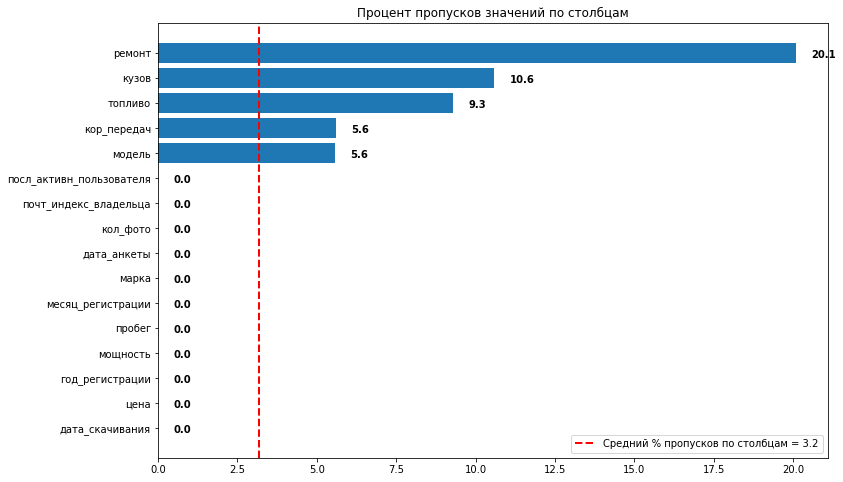

In [24]:
percentage_of_nan(df_rus)

Посмотрим корреляцию значений столбцов друг с другом. Может пригодится при заполнении пропусков.

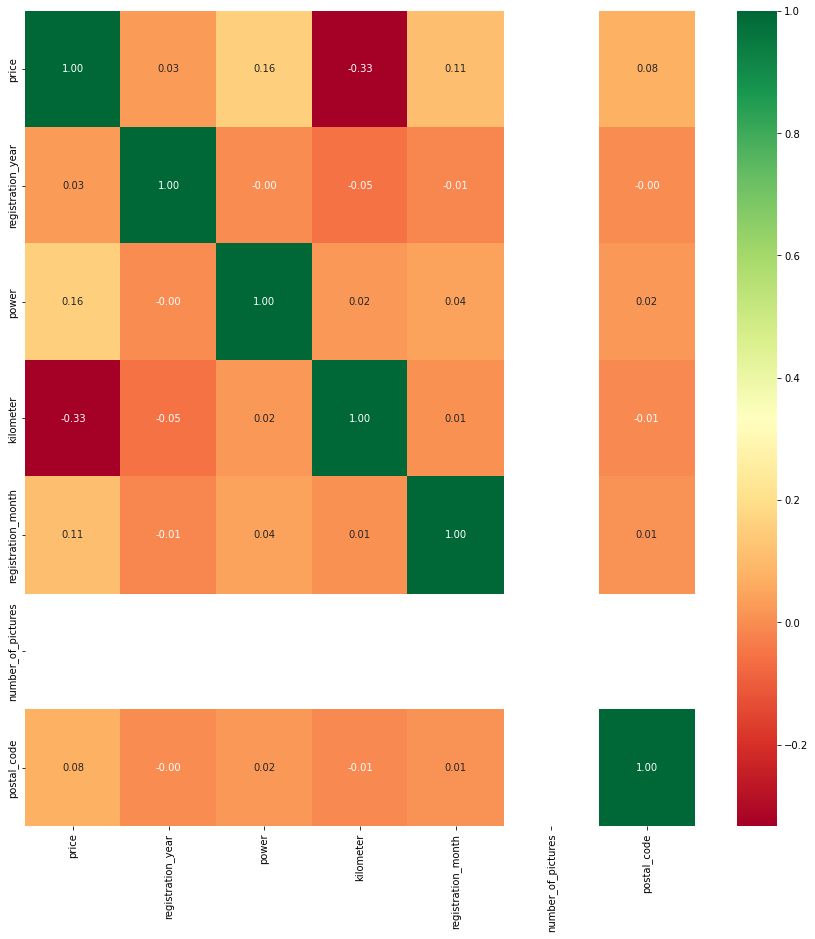

In [25]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),
            annot=True,
            cmap='RdYlGn',
            fmt='.2f')
plt.show()

##### Вывод

    - не корректный формат данных (не в формате даты):
        - дата_скачивания
        - дата_анкеты
        - посл_активн_пользователя
    - имеется 4 полных дубликата в строках

#### Анализ данных

Отлавливаем артефакты в данных.

##### дата_скачивания / date_crawled

'дата_скачивания:'

array(['2016-03-05T14:06:22.000000000', '2016-03-05T14:06:23.000000000',
       '2016-03-05T14:06:24.000000000', ...,
       '2016-04-07T14:36:55.000000000', '2016-04-07T14:36:56.000000000',
       '2016-04-07T14:36:58.000000000'], dtype='datetime64[ns]')

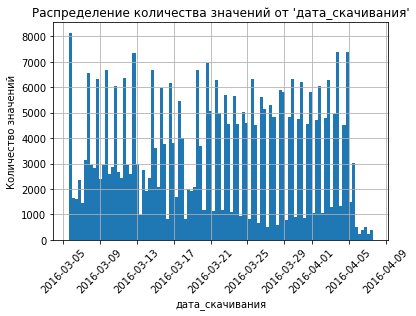

In [27]:
display('дата_скачивания:', df['date_crawled'].sort_values().unique())
print()
display(df['date_crawled'].hist(bins = 100))
plt.title("Распределение количества значений от 'дата_скачивания'")
plt.xlabel("дата_скачивания")
plt.xticks(rotation = 45)
plt.ylabel("Количество значений")
plt.show()

##### цена / price

'цена:'

array([    0,     1,     2, ..., 19998, 19999, 20000])

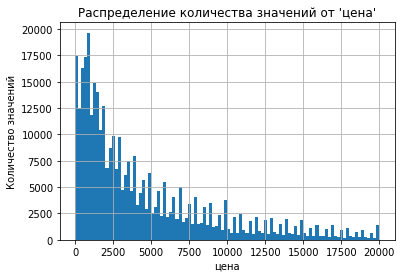

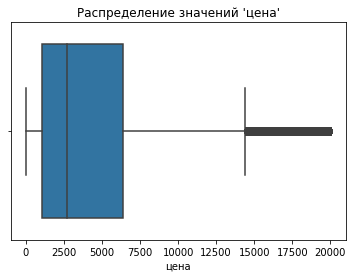

In [28]:
display('цена:', df['price'].sort_values().unique())
print()
display(df['price'].hist(bins = 100))
plt.title("Распределение количества значений от 'цена'")
plt.xlabel("цена")
plt.ylabel("Количество значений")
plt.show()
display(ax = sns.boxplot(data = df,
                         x = 'price',
                         orient = 'h'))
plt.title("Распределение значений 'цена'")
plt.xlabel("цена")
plt.show()

##### кузов / vehicle_type

'кузов:'

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

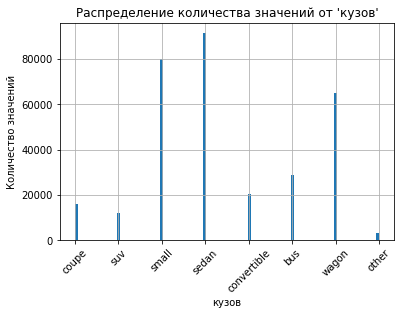

In [30]:
display('кузов:', df['vehicle_type'].sort_values().unique())
print()
display(df['vehicle_type'].hist(bins = 100))
plt.title("Распределение количества значений от 'кузов'")
plt.xlabel("кузов")
plt.xticks(rotation = 45)
plt.ylabel("Количество значений")
plt.show()

##### год_регистрации / registration_year

'год_регистрации:'

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

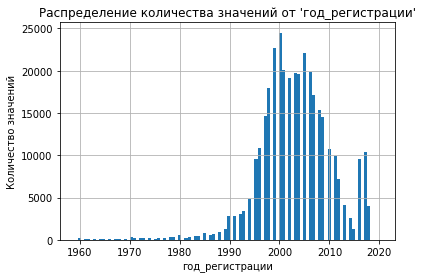

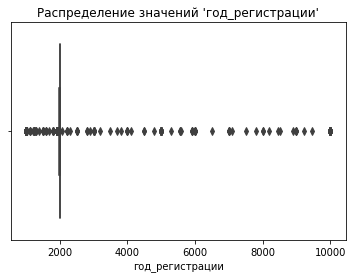

In [40]:
display('год_регистрации:', df['registration_year'].sort_values().unique())
print()
display(df['registration_year'].hist(bins = 100,
                                     range = (1959, 2020))) # много выбросов, скрываем
plt.title("Распределение количества значений от 'год_регистрации'")
plt.xlabel("год_регистрации")
plt.ylabel("Количество значений")
plt.show()
display(ax = sns.boxplot(data = df,
                         x = 'registration_year',
                         orient = 'h'))
plt.title("Распределение значений 'год_регистрации'")
plt.xlabel("год_регистрации")
plt.show()

##### кор_передач / gearbox

'кор_передач:'

array(['auto', 'manual', nan], dtype=object)

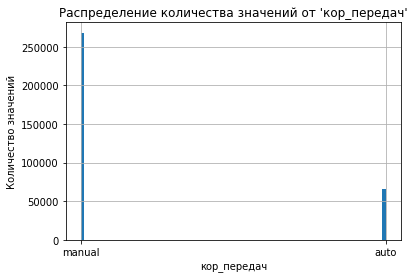

In [34]:
display('кор_передач:', df['gearbox'].sort_values().unique())
print()
display(df['gearbox'].hist(bins = 100))
plt.title("Распределение количества значений от 'кор_передач'")
plt.xlabel("кор_передач")
plt.ylabel("Количество значений")
plt.show()

##### мощность / power


'мощность:'

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

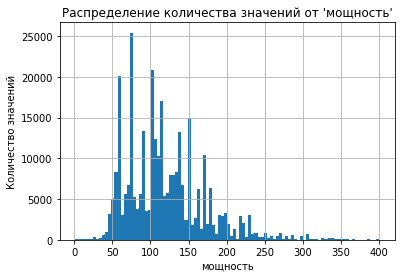

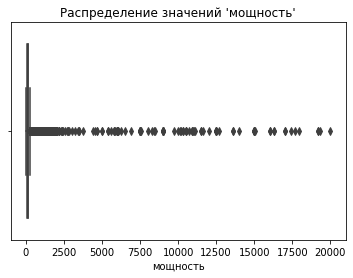

In [44]:
display('мощность:', df['power'].sort_values().unique())
print()
display(df['power'].hist(bins = 100,
                         range = (1, 400))) # много выбросов, скрываем
plt.title("Распределение количества значений от 'мощность'")
plt.xlabel("мощность")
plt.ylabel("Количество значений")
plt.show()
display(ax = sns.boxplot(data = df,
                         x = 'power',
                         orient = 'h'))
plt.title("Распределение значений 'мощность'")
plt.xlabel("мощность")
plt.show()

##### модель / model


In [47]:
print('\nмодель:\n')
loc = df['model'].sort_values().unique()
for i in range(len(loc)):
    print(loc[i])


модель:

100
145
147
156
159
1_reihe
1er
200
2_reihe
300c
3_reihe
3er
4_reihe
500
5_reihe
5er
601
6_reihe
6er
7er
80
850
90
900
9000
911
a1
a2
a3
a4
a5
a6
a8
a_klasse
accord
agila
alhambra
almera
altea
amarok
antara
arosa
astra
auris
avensis
aveo
aygo
b_klasse
b_max
beetle
berlingo
bora
boxster
bravo
c1
c2
c3
c4
c5
c_klasse
c_max
c_reihe
caddy
calibra
captiva
carisma
carnival
cayenne
cc
ceed
charade
cherokee
citigo
civic
cl
clio
clk
clubman
colt
combo
cooper
cordoba
corolla
corsa
cr_reihe
croma
crossfire
cuore
cx_reihe
defender
delta
discovery
doblo
ducato
duster
e_klasse
elefantino
eos
escort
espace
exeo
fabia
fiesta
focus
forester
forfour
fortwo
fox
freelander
fusion
g_klasse
galant
galaxy
getz
gl
glk
golf
grand
i3
i_reihe
ibiza
impreza
insignia
jazz
jetta
jimny
juke
justy
ka
kadett
kaefer
kalina
kalos
kangoo
kappa
kuga
laguna
lancer
lanos
legacy
leon
lodgy
logan
lupo
lybra
m_klasse
m_reihe
materia
matiz
megane
meriva
micra
mii
modus
mondeo
move
musa
mustang
mx_reihe
navara
niva
not

##### пробег / kilometer

'пробег:'

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000])

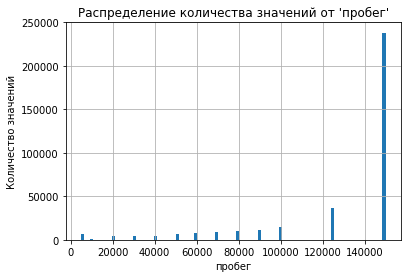

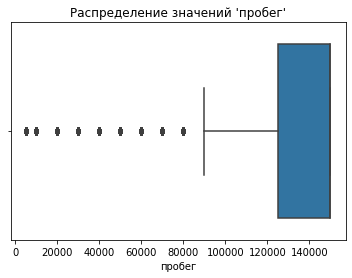

In [48]:
display('пробег:', df['kilometer'].sort_values().unique())
print()
display(df['kilometer'].hist(bins = 100))
plt.title("Распределение количества значений от 'пробег'")
plt.xlabel("пробег")
plt.ylabel("Количество значений")
plt.show()
display(ax = sns.boxplot(data = df,
                         x = 'kilometer',
                         orient = 'h'))
plt.title("Распределение значений 'пробег'")
plt.xlabel("пробег")
plt.show()

##### месяц_регистрации / registration_month

'месяц_регистрации:'

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

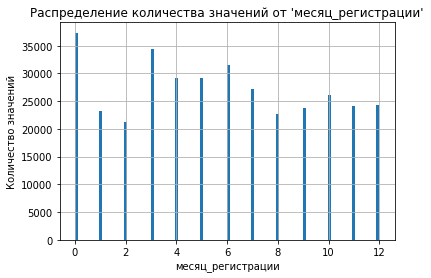

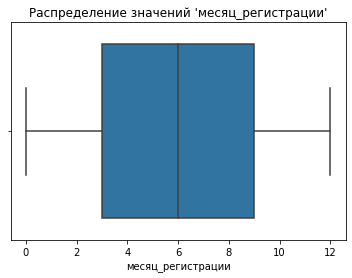

In [49]:
display('месяц_регистрации:', df['registration_month'].sort_values().unique())
print()
display(df['registration_month'].hist(bins = 100))
plt.title("Распределение количества значений от 'месяц_регистрации'")
plt.xlabel("месяц_регистрации")
plt.ylabel("Количество значений")
plt.show()
display(ax = sns.boxplot(data = df,
                         x = 'registration_month',
                         orient = 'h'))
plt.title("Распределение значений 'месяц_регистрации'")
plt.xlabel("месяц_регистрации")
plt.show()

##### топливо / fuel_type

'топливо:'

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

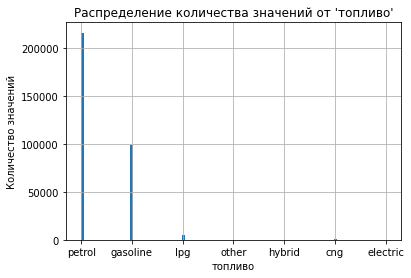

In [51]:
display('топливо:', df['fuel_type'].sort_values().unique())
print()
display(df['fuel_type'].hist(bins = 100))
plt.title("Распределение количества значений от 'топливо'")
plt.xlabel("топливо")
plt.ylabel("Количество значений")
plt.show()

##### марка / brand


марка:

alfa_romeo
audi
bmw
chevrolet
chrysler
citroen
dacia
daewoo
daihatsu
fiat
ford
honda
hyundai
jaguar
jeep
kia
lada
lancia
land_rover
mazda
mercedes_benz
mini
mitsubishi
nissan
opel
peugeot
porsche
renault
rover
saab
seat
skoda
smart
sonstige_autos
subaru
suzuki
toyota
trabant
volkswagen
volvo



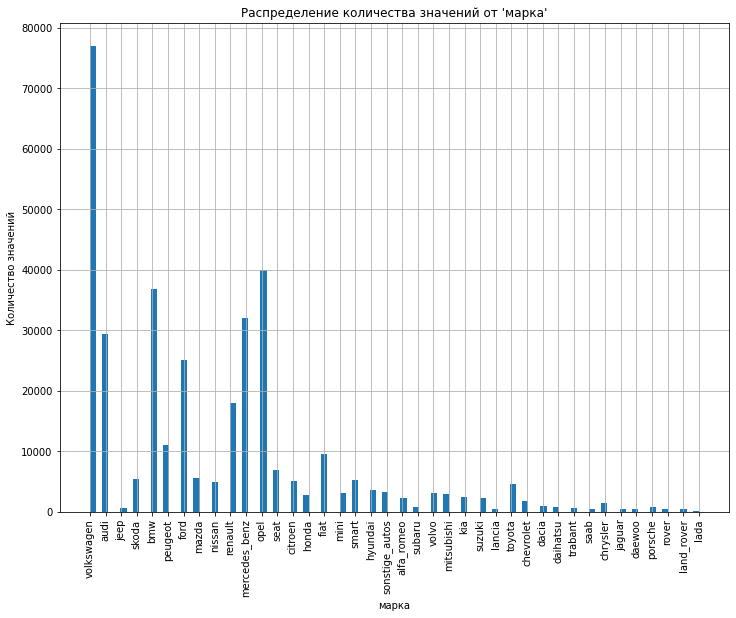

In [63]:
print('\nмарка:\n')
loc = df['brand'].sort_values().unique()
for i in range(len(loc)):
    print(loc[i])
print()
display(df['brand'].hist(bins = 100,
                         figsize = (12, 9)))
plt.title("Распределение количества значений от 'марка'")
plt.xlabel("марка")
plt.xticks(rotation = 90)
plt.ylabel("Количество значений")
plt.show()

##### ремонт / not_repaired

'ремонт:'

array(['no', 'yes', nan], dtype=object)

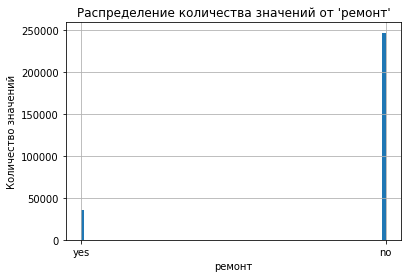

In [65]:
display('ремонт:', df['not_repaired'].sort_values().unique())
print()
display(df['not_repaired'].hist(bins = 100))
plt.title("Распределение количества значений от 'ремонт'")
plt.xlabel("ремонт")
plt.ylabel("Количество значений")
plt.show()

##### дата_анкеты / date_created

'дата_анкеты:'

array(['2014-03-10T00:00:00.000000000', '2015-03-20T00:00:00.000000000',
       '2015-06-18T00:00:00.000000000', '2015-08-07T00:00:00.000000000',
       '2015-08-10T00:00:00.000000000', '2015-09-04T00:00:00.000000000',
       '2015-09-09T00:00:00.000000000', '2015-11-02T00:00:00.000000000',
       '2015-11-08T00:00:00.000000000', '2015-11-10T00:00:00.000000000',
       '2015-11-12T00:00:00.000000000', '2015-11-17T00:00:00.000000000',
       '2015-11-23T00:00:00.000000000', '2015-11-24T00:00:00.000000000',
       '2015-12-05T00:00:00.000000000', '2015-12-06T00:00:00.000000000',
       '2015-12-17T00:00:00.000000000', '2015-12-27T00:00:00.000000000',
       '2015-12-30T00:00:00.000000000', '2016-01-02T00:00:00.000000000',
       '2016-01-03T00:00:00.000000000', '2016-01-06T00:00:00.000000000',
       '2016-01-07T00:00:00.000000000', '2016-01-08T00:00:00.000000000',
       '2016-01-10T00:00:00.000000000', '2016-01-13T00:00:00.000000000',
       '2016-01-15T00:00:00.000000000', '2016-01-16

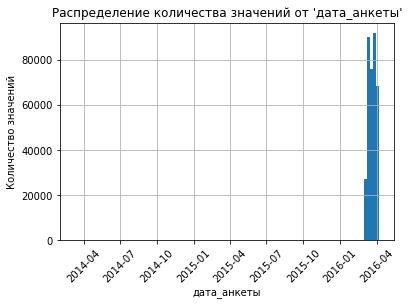

In [73]:
display('дата_анкеты:', df['date_created'].sort_values().unique())
print()
display(df['date_created'].hist(bins = 100))
plt.title("Распределение количества значений от 'дата_анкеты'")
plt.xlabel("дата_анкеты")
plt.xticks(rotation = 45)
plt.ylabel("Количество значений")
plt.show()

##### кол_фото / number_of_pictures

In [75]:
display('кол_фото:', df['number_of_pictures'].sort_values().unique())

'кол_фото:'

array([0])

##### почт_индекс / postal_code

'почт_индекс:'

array([ 1067,  1068,  1069, ..., 99994, 99996, 99998])

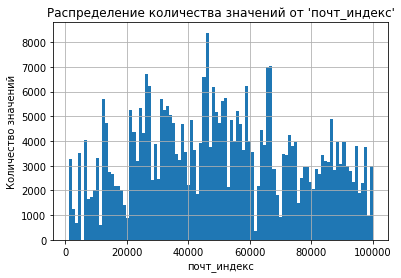

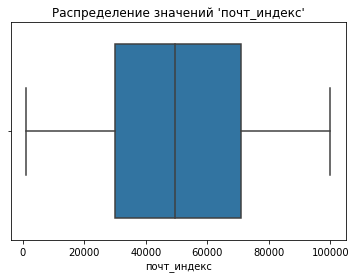

In [77]:
display('почт_индекс:', df['postal_code'].sort_values().unique())
print()
display(df['postal_code'].hist(bins = 100))
plt.title("Распределение количества значений от 'почт_индекс'")
plt.xlabel("почт_индекс")
plt.ylabel("Количество значений")
plt.show()
display(ax = sns.boxplot(data = df,
                         x = 'postal_code',
                         orient = 'h'))
plt.title("Распределение значений 'почт_индекс'")
plt.xlabel("почт_индекс")
plt.show()

##### посл_активн / last_seen

'посл_активн:'

array(['2016-03-05T14:15:08.000000000', '2016-03-05T14:15:16.000000000',
       '2016-03-05T14:15:39.000000000', ...,
       '2016-04-07T14:58:49.000000000', '2016-04-07T14:58:50.000000000',
       '2016-04-07T14:58:51.000000000'], dtype='datetime64[ns]')

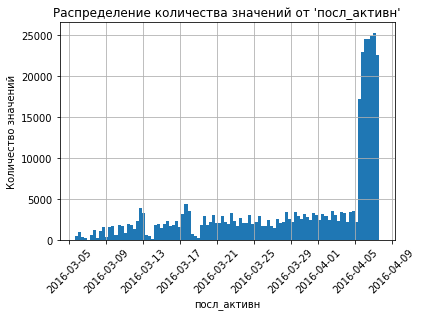

In [81]:
display('посл_активн:', df['last_seen'].sort_values().unique())
print()
display(df['last_seen'].hist(bins = 100))
plt.title("Распределение количества значений от 'посл_активн'")
plt.xlabel("посл_активн")
plt.xticks(rotation = 45)
plt.ylabel("Количество значений")
plt.show()

##### Вывод

    - "цена": 0, 1 и 2 - это привлекательно, но сомнительно
    - "год_регистрации" и "мощность": довольно разнообразный мусор, возможна техническая ошибка
    - "месяц_регистрации": месяца 0 не бывает
    - "дата_анкеты": 2015, и особенно 2014 представлены не полно
    - "кол_фото": фотографий нет нигде
    - "почт_индекс_владельца": выглядит сомнительно, ни одной правильной цифры, должно быть по 6 знаков (возможно закодировано)
    - "посл_активн_пользователя": отсутствуют данные за 2014 и 2015 год

## Подготовка данных

### Пропуски

#### 'ремонт' : 'not_repaired'

В колонке `ремонт` пропуски могут быть вызваны:

    - машина не чинилась;
    - машина чинилась, но это хотят скрыть. 

Заполним пропуски значением unknown.

In [82]:
df['not_repaired'] = df['not_repaired'].fillna('unknown')
#df.isna().mean().sort_values(ascending=False) * 100

#### 'модель' : 'model'

Модель авто влияет на цену. У каждого бренда больше 1 модели, поэтому заполнить корректно пропуски невозможно. 

Пропусков 5,6%. Удаляем.

Сначала обрабатываем "модель", потом остальное.

In [83]:
df = df.loc[~df['model'].isna()]
#df.isna().mean().sort_values(ascending=False) * 100

#### 'кузов' : 'vehicle_type'

#### 'кор_передач' : 'gearbox'

#### 'топливо' : 'fuel_type'

Тип кузова и топлива, а также коробку передач восстановим по марке и модели, используя наиболее частые значения.

In [84]:
df['vehicle_type'] = df['vehicle_type'].fillna(
                              df.groupby('model')['vehicle_type'].transform(
                                    lambda x: x.value_counts().idxmax()))
df['gearbox'] = df['gearbox'].fillna(
                              df.groupby('model')['gearbox'].transform(
                                    lambda x: x.value_counts().idxmax()))
df['fuel_type'] = df['fuel_type'].fillna(
                              df.groupby('model')['fuel_type'].transform(
                                    lambda x: x.value_counts().idxmax()))
df.isna().mean().sort_values(ascending=False) * 100

date_crawled         0.000
price                0.000
vehicle_type         0.000
registration_year    0.000
gearbox              0.000
power                0.000
model                0.000
kilometer            0.000
registration_month   0.000
fuel_type            0.000
brand                0.000
not_repaired         0.000
date_created         0.000
number_of_pictures   0.000
postal_code          0.000
last_seen            0.000
dtype: float64

### Аномалии

#### 'цена' : 'price'

Посмотрим распределение цен.

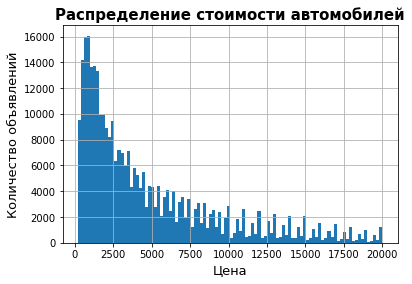

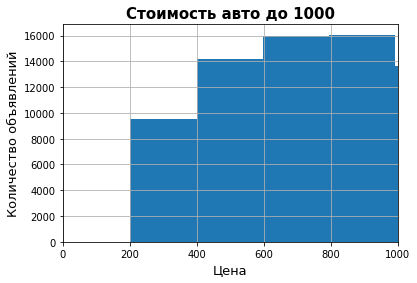


Количество строк ценой до 200 евро:  0
Процент строк ценой до 200 евро: 0.00%


In [94]:
df['price'].hist(bins = 100)
plt.xlabel('Цена',
           fontsize = 13)
plt.ylabel('Количество объявлений',
           fontsize = 13)
plt.title('Распределение стоимости автомобилей',
          fontsize = 15,
          fontweight = 'bold')
plt.show()
df['price'].hist(bins = 100)
plt.xlabel('Цена',
           fontsize = 13)
plt.ylabel('Количество объявлений',
           fontsize = 13)
plt.xlim([0, 1000])
plt.title('Стоимость авто до 1000',
          fontsize = 15,
          fontweight = 'bold')
plt.show()
print('\nКоличество строк ценой до 200 евро: ',len(df.loc[df['price'] <= 200]))
print('Процент строк ценой до 200 евро: {:.2%}'.format(len(df.loc[df['price'] <= 200]) / len(df)))

Просмотр на увеличенном масштабе начала графика позволяет отсеч значения цен до 200 евро.

Цены в 0, 1, 2 и т.д. евро быть не может, а график подсказал, что вторая "ступень" начинается с 200.

Жертвуем 4.81% данных.

In [89]:
df = df.loc[df['price'] > 200]

Проверяем.

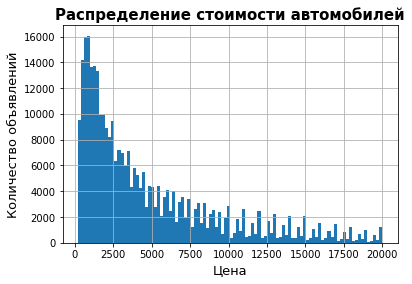

In [90]:
df['price'].hist(bins = 100)
plt.xlabel('Цена',
           fontsize = 13)
plt.ylabel('Количество объявлений',
           fontsize = 13)
plt.title('Распределение стоимости автомобилей',
          fontsize = 15,
          fontweight = 'bold')
plt.show()

#### 'год_регистрации' : 'registration_year'

Посмотрим распределение по годам регистрации.

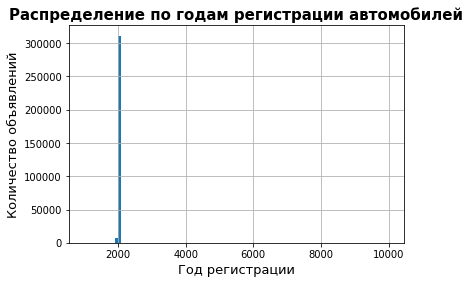

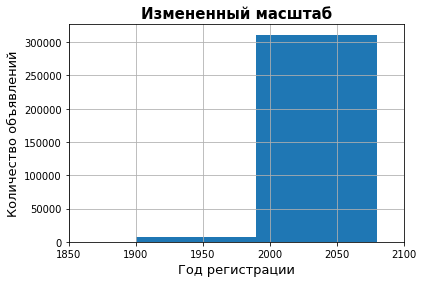


Количество строк до 1960:  166
Процент строк до 1960: 0.05%

Количество строк после 2016:  11753
Процент строк после 2016: 3.69%

Итого: 3.74%


In [101]:
df['registration_year'].hist(bins = 100)
plt.xlabel('Год регистрации',
           fontsize = 13)
plt.ylabel('Количество объявлений',
           fontsize = 13)
plt.title('Распределение по годам регистрации автомобилей',
          fontsize = 15,
          fontweight = 'bold')
plt.show()
df['registration_year'].hist(bins = 100)
plt.xlabel('Год регистрации',
           fontsize = 13)
plt.ylabel('Количество объявлений',
           fontsize = 13)
plt.xlim([1850, 2100])
plt.title('Измененный масштаб',
          fontsize = 15,
          fontweight = 'bold')
plt.show()

print('\nКоличество строк до 1960: ', len(df.loc[df['registration_year'] < 1960]))
print('Процент строк до 1960: {:.2%}'.format(len(df.loc[df['registration_year'] < 1960]) / len(df)))
print('\nКоличество строк после 2016: ', len(df.loc[df['registration_year'] > 2016]))
print('Процент строк после 2016: {:.2%}'.format(len(df.loc[df['registration_year'] > 2016]) / len(df)))
print('\nИтого: {:.2%}'.format(len(df.loc[df['registration_year'] < 1960]) / len(df) + 
                               len(df.loc[df['registration_year'] > 2016]) / len(df)))

Отсекаем значения более 2016 т.к. данные предоставлены до '2016-04-07 14:58:51' и менее 1960 (согласно графика).

In [102]:
df = df.loc[(df['registration_year'] >= 1960) & 
            (df['registration_year'] <= 2016)]

Проверяем.

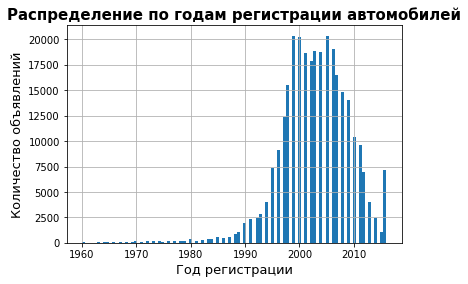

In [103]:
df['registration_year'].hist(bins = 100)
plt.xlabel('Год регистрации',
           fontsize = 13)
plt.ylabel('Количество объявлений',
           fontsize = 13)
plt.title('Распределение по годам регистрации автомобилей',
          fontsize = 15,
          fontweight = 'bold')
plt.show()

#### 'мощность' : 'power'

Посмотрим распределение мощностей/

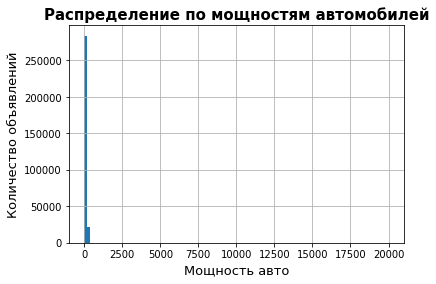

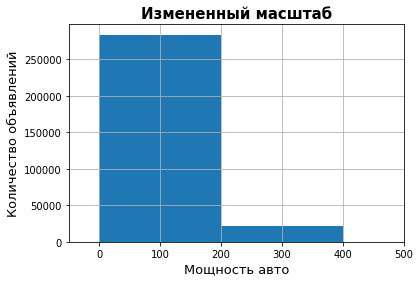


Количество строк до 50 л.с.:  30159
Процент строк до 50 л.с.: 9.84%

Количество строк выше 600:  340
Процент строк выше 600: 0.11%

Итого: 9.95%


In [108]:
df['power'].hist(bins = 100)
plt.xlabel('Мощность авто',
           fontsize = 13)
plt.ylabel('Количество объявлений',
           fontsize = 13)
plt.title('Распределение по мощностям автомобилей',
          fontsize = 15,
          fontweight = 'bold')
plt.show()
df['power'].hist(bins = 100)
plt.xlabel('Мощность авто',
           fontsize = 13)
plt.ylabel('Количество объявлений',
           fontsize = 13)
plt.xlim([-50, 500])
plt.title('Измененный масштаб',
          fontsize = 15,
          fontweight = 'bold')
plt.show()

print('\nКоличество строк до 50 л.с.: ', len(df.loc[df['power'] < 50]))
print('Процент строк до 50 л.с.: {:.2%}'.format(len(df.loc[df['power'] < 50]) / len(df)))
print('\nКоличество строк выше 600: ', len(df.loc[df['power'] > 500]))
print('Процент строк выше 600: {:.2%}'.format(len(df.loc[df['power'] > 500]) / len(df)))
print('\nИтого: {:.2%}'.format(len(df.loc[df['power'] < 50]) / len(df) + 
                               len(df.loc[df['power'] > 500]) / len(df)))

Убираем значения менее 50 л.с. т.к. даже ВАЗ2101 имел 64 и более 600 (согласно графика).

Это еще 9.95%.

In [109]:
df = df.loc[(df['power'] >= 50) & 
            (df['power'] <= 500)]

Проверяем.

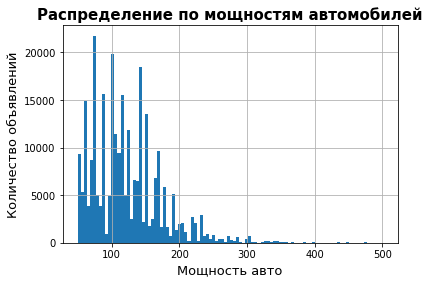

In [110]:
df['power'].hist(bins = 100)
plt.xlabel('Мощность авто',
           fontsize = 13)
plt.ylabel('Количество объявлений',
           fontsize = 13)
plt.title('Распределение по мощностям автомобилей',
          fontsize = 15,
          fontweight = 'bold')
plt.show()

#### 'дата_скачивания' : 'date_crawled'

#### 'дата_анкеты' : 'date_created'

#### 'посл_активн_пользователя' : 'last_seen'

#### 'кол_фото' : 'number_of_pictures'

#### 'месяц_регистрации' : 'registration_month'

    - Колонки `дата_скачивания` (date_crawled), `дата_анкеты` (date_created) и `посл_активн_пользователя` (last_seen) на цену не влияют.
    - Фотографий ('number_of_pictures') нигде нет.
    - Возраст автомобиля определяют по году регистрации, не учитывая месяц ('registration_month').

Эти 5 колонок и удаляем.

In [111]:
df=df.drop(['date_crawled',
            'date_created',
            'last_seen',
            'number_of_pictures',
            'registration_month'],
            axis = 1)

Поменяем формат столбцов gearbox и not_repaired на булевый тип, чтобы без вариантов одно из двух значений.

In [112]:
df['manual_gearbox'] = 0                                   # 0 - автоматическая коробка передач
df.loc[df['gearbox'] == 'manual', 'manual_gearbox'] = 1    # 1 - механическая коробка передач
display(df['manual_gearbox'].value_counts())
display(df['gearbox'].value_counts())

df['is_not_repaired'] = 0                                  # не ремонтировалась
df.loc[df['not_repaired'] == 'yes', 'is_not_repaired'] = 1 # ремонтировалась
display(df['is_not_repaired'].value_counts())
display(df['not_repaired'].value_counts())

1    219807
0     56332
Name: manual_gearbox, dtype: int64

manual    219807
auto       56332
Name: gearbox, dtype: int64

0    251064
1     25075
Name: is_not_repaired, dtype: int64

no         214594
unknown     36470
yes         25075
Name: not_repaired, dtype: int64

Удалим теперь ненужные столбцы.

In [113]:
df.drop(['not_repaired','gearbox'],
        inplace=True,
        axis=1)

Почистим дубликаты.

In [114]:
df = df.drop_duplicates()

Посмотрим получившуюся таблицу.

In [115]:
display(df.head())
df_info(df)
print('\nВсего было удалено: {:.2%}'.format((len(df_rus) - len(df)) / len(df_rus)),' строк.')

,price,vehicle_type,registration_year,power,model,kilometer,fuel_type,brand,postal_code,manual_gearbox,is_not_repaired
2,9800,suv,2004,163,grand,125000,gasoline,jeep,90480,0,0
3,1500,small,2001,75,golf,150000,petrol,volkswagen,91074,1,0
4,3600,small,2008,69,fabia,90000,gasoline,skoda,60437,1,0
5,650,sedan,1995,102,3er,150000,petrol,bmw,33775,1,1
6,2200,convertible,2004,109,2_reihe,150000,petrol,peugeot,67112,1,0



Инфо:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 252879 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              252879 non-null  int64 
 1   vehicle_type       252879 non-null  object
 2   registration_year  252879 non-null  int64 
 3   power              252879 non-null  int64 
 4   model              252879 non-null  object
 5   kilometer          252879 non-null  int64 
 6   fuel_type          252879 non-null  object
 7   brand              252879 non-null  object
 8   postal_code        252879 non-null  int64 
 9   manual_gearbox     252879 non-null  int64 
 10  is_not_repaired    252879 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 23.2+ MB
None

Пропусков:
price               0.000
vehicle_type        0.000
registration_year   0.000
power               0.000
model               0.000
kilometer           0.000
fuel_type           0.000
brand   

,price,registration_year,power,kilometer,postal_code,manual_gearbox,is_not_repaired
count,"252,879.000","252,879.000","252,879.000","252,879.000","252,879.000","252,879.000","252,879.000"
mean,"4,998.098","2,003.106",122.372,"128,377.426","51,693.127",0.797,0.094
std,"4,625.693",6.151,52.419,"36,502.085","25,747.870",0.402,0.292
min,202.000,"1,960.000",50.000,"5,000.000","1,067.000",0.000,0.000
25%,"1,450.000","1,999.000",82.000,"125,000.000","31,228.000",1.000,0.000
50%,"3,350.000","2,003.000",115.000,"150,000.000","50,827.000",1.000,0.000
75%,"7,199.000","2,007.000",150.000,"150,000.000","72,505.000",1.000,0.000
max,"20,000.000","2,016.000",500.000,"150,000.000","99,998.000",1.000,1.000



Дубликатов = 0

Всего было удалено: 28.64%  строк.


Проверим признаки на независимость.

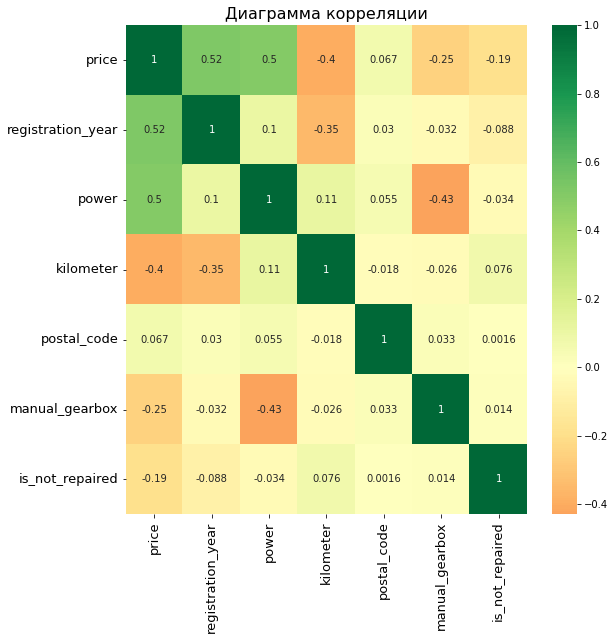

In [125]:
plt.figure(figsize = (9, 9))
sns.heatmap(df.corr(),
            xticklabels = df.corr().columns,
            yticklabels = df.corr().columns,
            cmap = 'RdYlGn',
            center = 0,
            annot = True)
plt.title('Диаграмма корреляции',
          fontsize = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.show()

## Обучение моделей

In [126]:
random_state = 1980

Создадим обучающую и тестовую выборки в соотношении 75:25.

In [131]:
target = df['price']
features = df.drop('price',
                   axis = 1)
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size = 0.25,
                                                                            random_state = random_state)
print('Обучающая выборка: ', features_train.shape,  target_train.shape)
print('Тестовая выборка:  ', features_test.shape,   target_test.shape)

Обучающая выборка:  (189659, 10) (189659,)
Тестовая выборка:   (63220, 10) (63220,)


Для более простых моделей используем кодирование OHE.

In [136]:
df_ohe = pd.get_dummies(df, 
                        drop_first = True)
#display(df_ohe.head(5))
target_ohe = df_ohe['price']
features_ohe = df_ohe.drop('price', 
                           axis = 1)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe,
                                                                                            target_ohe,
                                                                                            test_size = 0.25,
                                                                                            random_state = random_state)
print('\nОбучающая выборка OHE: ', features_train_ohe.shape,  target_train_ohe.shape)
print('Тестовая выборка OHE:  ', features_test_ohe.shape,  target_test_ohe.shape, '\n')
df_ohe


Обучающая выборка OHE:  (189659, 305) (189659,)
Тестовая выборка OHE:   (63220, 305) (63220,) 



,price,registration_year,power,kilometer,postal_code,manual_gearbox,is_not_repaired,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,...,brand_saab,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
2,9800,2004,163,125000,90480,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,91074,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3600,2008,69,90000,60437,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,650,1995,102,150000,33775,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2200,2004,109,150000,67112,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,2016,150,150000,51371,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354362,3200,2004,225,150000,96465,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
354366,1199,2000,101,125000,26135,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
354367,9200,1996,102,150000,87439,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Константная модель

Создадим константную модель, которая любому объекту будет предсказывать среднее значение и посчитаем для нее метрику RMSE. С ней и будем сравнивать все последующие модели.

In [137]:
%%time
predicted_const = pd.Series(target_test.mean(),
                            index = target_test.index)
rmse_const = mean_squared_error(target_test, predicted_const)**0.5
print('RMSE константной модели: {:.2f}'. format(rmse_const))

RMSE константной модели: 4635.53
CPU times: user 4.82 ms, sys: 955 µs, total: 5.78 ms
Wall time: 7.29 ms


In [157]:
predict_time_const = '7.29 ms'

### LinearRegression

In [138]:
# Wall time: 2min 24s
%%time
lr = LinearRegression()
params_lr = {#'normalize':[True,False],
             'normalize':[True,False],
             #'copy_X':[True, False]
             'copy_X':[True, False]}
calc_gscv(lr,
          features_train_ohe,
          target_train_ohe,
          params_lr)
'''
RMSE модели на обучающей выборке:2541.89
'''

RMSE модели на обучающей выборке:50.59
Лучшие гиперпараметры для модели:  {'copy_X': True, 'normalize': False}
CPU times: user 10.9 s, sys: 3.04 s, total: 13.9 s
Wall time: 2min 24s


In [148]:
learning_time_lr = '2min 24s'

### DecisionTreeRegressor

In [140]:
# Wall time: 19min 13s
%%time
dtr = DecisionTreeRegressor(random_state = random_state)
params_dtr = {'max_depth': range(1, 51, 2),
              #'max_depth': range(1, 51, 2),
              #'splitter': ['best', 'random']
              'splitter': ['best', 'random']}
calc_gscv(dtr,
          features_train_ohe,
          target_train_ohe,
          params_dtr )
'''
RMSE модели на обучающей выборке:1899.29
'''

RMSE модели на обучающей выборке: 43.41
Лучшие гиперпараметры для модели:  {'max_depth': 15, 'splitter': 'best'}
CPU times: user 13.9 s, sys: 1.91 s, total: 15.8 s
Wall time: 19min 13s


In [158]:
learning_time_dtr = '19min 13s'

### CatBoost

Создадим список категориальных признаков.

In [141]:
features_cbr = ['vehicle_type',
                'manual_gearbox',
                'model',
                'fuel_type',
                'brand',
                'is_not_repaired']

In [142]:
# Wall time: 14min 4s
%%time
# Ищем лучшие параметры и метрику RMSE на обучающей выборке с этими параметрами
cbr = CatBoostRegressor(iterations = 100,
                        verbose = False,
                        cat_features = features_cbr)
params_cbr = {'learning_rate':[0.1, 0.3, 0.5],
              #'learning_rate':[0.1, 0.3, 0.5],
              #'depth':[5, 10, 15]
              'depth':[5, 10, 15]} 
grid_cbr = GridSearchCV(cbr,
                        params_cbr,
                        scoring = 'neg_mean_squared_error',
                        cv = 3,
                        n_jobs = -1)
grid_cbr.fit(features,
             target)
rmse = (-grid_cbr.best_score_)**0.5
print('RMSE модели CatBoost на обучающей выборке: {:.2f}'.format(rmse))
print('Лучшие гиперпараметры для модели: ', grid_cbr.best_params_)
'''
# RMSE модели CatBoost на обучающей выборке:1564.03
'''

RMSE модели CatBoost на обучающей выборке: 1573.70
Лучшие гиперпараметры для модели:  {'depth': 15, 'learning_rate': 0.3}
CPU times: user 1min 56s, sys: 24 s, total: 2min 20s
Wall time: 14min 4s


In [159]:
learning_time_cbr = '14min 4s'

### LightGBM

Меняем тип категориальных признаков на 'category'.

In [143]:
df_lgbmr = df
df_lgbmr[['vehicle_type',
          'manual_gearbox',
          'model',
          'fuel_type',
          'brand',
          'is_not_repaired']] = df_lgbmr[['vehicle_type',
                                          'manual_gearbox',
                                          'model',
                                          'fuel_type',
                                          'brand',
                                          'is_not_repaired']].astype('category')

Пересоздадим обучающую и тестовую выборки.

In [144]:
target_lgbmr = df_lgbmr['price']
features_lgbmr = df_lgbmr.drop('price',
                               axis = 1)
features_train_lgbmr, features_test_lgbmr, target_train_lgbmr, target_test_lgbmr = train_test_split(features_lgbmr,
                                                                                                    target_lgbmr, 
                                                                                                    test_size = 0.25, 
                                                                                                    random_state = random_state)

In [145]:
%%time
estim = LGBMRegressor(random_state = random_state)
params = {'n_estimators': [60, 150, 300],
          #n_estimators': [60, 150],
          'num_leaves': [21, 51, 101],
          #'num_leaves': [21, 51, 101],
          #'learning_rate':[0.1, 0.3, 0.5],
          'learning_rate':[0.1, 0.3, 0.5],
          #'boosting_type':['gbdt', 'dart', 'goss'],
          'boosting_type':['gbdt', 'dart', 'goss']
         }
grid_lgbmr = GridSearchCV(estimator = estim, 
                          param_grid = params, 
                          cv = 3,
                          #scoring = 'neg_mean_squared_error',
                          scoring = 'neg_root_mean_squared_error',
                          n_jobs = -1)

CPU times: user 273 µs, sys: 0 ns, total: 273 µs
Wall time: 283 µs


In [146]:
# Wall time: 38min 25s
%%time
grid_lgbmr.fit(features_lgbmr, target_lgbmr)
print('RMSE модели LightGBM на обучающей выборке:{:.2f}'.format(grid_lgbmr.best_score_))
print('Лучшие гиперпараметры для модели: ',grid_lgbmr.best_params_)
'''
RMSE модели LightGBM на обучающей выборке:-2324643.19
'''

RMSE модели LightGBM на обучающей выборке:-1513.16
Лучшие гиперпараметры для модели:  {'boosting_type': 'dart', 'learning_rate': 0.3, 'n_estimators': 300, 'num_leaves': 101}
CPU times: user 3min 8s, sys: 2.59 s, total: 3min 10s
Wall time: 38min 25s


In [160]:
learning_time_lgbmr = '38min 25s'

## Анализ моделей

### LinearRegression

Обучим модель Линейной регрессии с найденными параметрами на тестовой выборке.

In [149]:
%%time
test_lr = LinearRegression(copy_X = True,
                           normalize = False)
test_lr.fit(features_train_ohe,
            target_train_ohe)

CPU times: user 10.8 s, sys: 720 ms, total: 11.5 s
Wall time: 6.41 s


In [161]:
fit_time_lr = '6.41 s'

In [150]:
%%time
predictions_lr = test_lr.predict(features_test_ohe)
mse = mean_squared_error(target_test_ohe,
                         predictions_lr)
rmse_lr = mse.mean()**0.5
print('RMSE модели Линейной регресии на тестовой выборке: {:.2f}'.format(rmse_lr))

RMSE модели Линейной регресии на тестовой выборке: 2574.95
CPU times: user 168 ms, sys: 94.4 ms, total: 262 ms
Wall time: 167 ms


In [162]:
predict_time_lr = '167 ms'

### DecisionTreeRegressor

Обучим модель Решающего дерева с найденными параметрами на тестовой выборке.

In [151]:
%%time
test_dtr = DecisionTreeRegressor(random_state = random_state, 
                                 max_depth = 16)
test_dtr.fit(features_train_ohe,
             target_train_ohe)

CPU times: user 5.61 s, sys: 85.4 ms, total: 5.69 s
Wall time: 5.62 s


In [163]:
fit_time_dtr = '5.62 s'

In [152]:
%%time
predictions_dtr = test_dtr.predict(features_test_ohe)
mse = mean_squared_error(target_test_ohe,
                         predictions_dtr)
rmse_dtr = mse.mean()**0.5
print('RMSE модели Решающего дерева на тестовой выборке: {:.2f}'.format(rmse_dtr))

RMSE модели Решающего дерева на тестовой выборке: 1846.97
CPU times: user 101 ms, sys: 82.5 ms, total: 183 ms
Wall time: 185 ms


In [164]:
predict_time_dtr = '185 ms'

### CatBoostRegressor

Обучим модель CatBoost на тестовой выборке.

In [153]:
%%time
test_cbr = CatBoostRegressor(iterations = 100,
                             verbose = False,
                             cat_features = features_cbr,
                             learning_rate = 0.3,
                             depth = 15,
                             random_state = random_state)
test_cbr.fit(features_train,
             target_train)

CPU times: user 1min 38s, sys: 22.7 s, total: 2min 1s
Wall time: 1min 9s


In [165]:
fit_time_cbr = '1min 9s'

In [154]:
%%time
predictions_cbr = test_cbr.predict(features_test)
mse = mean_squared_error(target_test,
                         predictions_cbr)
rmse_cbr = mse.mean()**0.5
print('RMSE модели CatBoost на тестовой выборке: {:.2f}'.format(rmse_cbr))

RMSE модели CatBoost на тестовой выборке: 1553.08
CPU times: user 216 ms, sys: 4.78 ms, total: 221 ms
Wall time: 148 ms


In [166]:
predict_time_cbr = '148 ms'

### LGBMRegressor

Обучим модель LightGBM на тестовой выборке.

In [155]:
%%time
categorial_features = ['vehicle_type',
                       'manual_gearbox',
                       'model',
                       'fuel_type',
                       'brand',
                       'is_not_repaired']
test_lgbmr = LGBMRegressor(iterations = 100,
                           verbose = 0,
                           random_state = random_state,
                           categorial_features = categorial_features,
                           learning_rate = 0.3,
                           n_estimators = 150,
                           num_leaves = 101,
                           depth = 5,
                           boosting_type = 'dart')
test_lgbmr.fit(features_train_lgbmr,
               target_train_lgbmr)

CPU times: user 39.1 s, sys: 106 ms, total: 39.2 s
Wall time: 20 s


In [167]:
fit_time_lgbmr = '20 s'

In [156]:
%%time
predictions_lgbmr = test_lgbmr.predict(features_test_lgbmr)
mse = mean_squared_error(target_test_lgbmr,predictions_lgbmr)
rmse_lgbmr = mse.mean()**0.5
print('RMSE для модели LGBM на тестовой выборке: {:.2f}'.format(rmse_lgbmr))

RMSE для модели LGBM на тестовой выборке: 1519.45
CPU times: user 1.52 s, sys: 5.32 ms, total: 1.52 s
Wall time: 780 ms


In [168]:
predict_time_lgbmr = '780 ms'

### Сводная таблица

Все посчитанное в одну табличку.

In [169]:
pivot = {"Модель":np.array(['Константная',
                            'LinearRegression',
                            'DecisionTreeRegressor',
                            'CatBoost',
                            'LightGBM']),
         "RMSE":np.array([rmse_const,
                          rmse_lr,
                          rmse_dtr,
                          rmse_cbr,
                          rmse_lgbmr]),
         "Время обучения":np.array(['-',
                                    fit_time_lr,
                                    fit_time_dtr,
                                    fit_time_cbr,
                                    fit_time_lgbmr]),
         "Время предсказания":np.array([predict_time_const,
                                        predict_time_lr,
                                        predict_time_dtr,
                                        predict_time_cbr,
                                        predict_time_lgbmr]),
         "Время подбора параметров":np.array(['-',
                                              learning_time_lr,
                                              learning_time_dtr,
                                              learning_time_cbr,
                                              learning_time_lgbmr])}
learning_time_lr = '7min 42s'
data = pd.DataFrame(pivot, index=['1', '2', '3', '4', '5'])
display(data)

,Модель,RMSE,Время обучения,Время предсказания,Время подбора параметров
1,Константная,"4,635.531",-,7.29 ms,-
2,LinearRegression,"2,574.952",6.41 s,167 ms,2min 24s
3,DecisionTreeRegressor,"1,846.966",5.62 s,185 ms,19min 13s
4,CatBoost,"1,553.078",1min 9s,148 ms,14min 4s
5,LightGBM,"1,519.448",20 s,780 ms,38min 25s


## Вывод

В ходе проекта были реализованы и протестированы несколько моделей предсказания рыночной стоимости своего автомобиля.

Требуемые параметры моделей сведены в приведенную выше таблицу.

Наименьшую среднюю ошибку (RMSE) показали модели:

    1. LightGBM              1518
    2. CatBoost              1552
    3. Решающее дерево       1852
    
Самыми быстрыми при обучении получились модели:

    1. Решающее дерево       3.48 ms
    2. Линейная регрессия    42.5 s
    3. CatBoost              1min 22s
    
Самыми быстрыми на предсказании получились модели:

    1. Решающее дерево       131 ms
    2. CatBoost              162 ms	
    3. Линейная регрессия    277 ms	

Получилось чем быстрее просчитывается результат, тем он менее точен.

В дополнительных условиях было указано "Значение метрики RMSE должно быть меньше 2500". Тогда быстрейшая модель обеспечивающая достаточную точность - это Решающее дерево.